<h3>Import Libraries</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

<h3>Load Subgroup2 training data</h3>

In [2]:
df = pd.read_csv("data/train_cluster2.csv")

y = df["Bankrupt?"].astype(int)
X = df.drop(columns=["Bankrupt?", "Index", "cluster_id"], errors="ignore")

print("Cluster 2 shape:", X.shape)
print("\nBankrupt counts:\n", y.value_counts())

Cluster 2 shape: (1976, 95)

Bankrupt counts:
 Bankrupt?
0    1972
1       4
Name: count, dtype: int64


<h3>Target Distribution</h3>

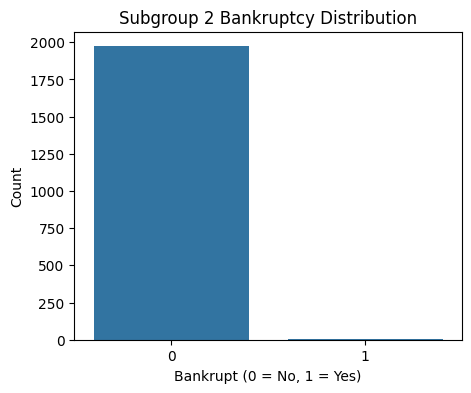

In [3]:
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Subgroup 2 Bankruptcy Distribution")
plt.xlabel("Bankrupt (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [4]:
# Feature Reduction
feature_reducer = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=40, random_state=42)) 
])

<h3>Define Oversampling + Stacking Model</h3>

In [5]:
# Oversample minority (bankrupt = 1) to balance the training set
ros = RandomOverSampler(sampling_strategy=1.0, random_state=42)

base_estimators = [
    ("svm", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42)),
    ("lr", LogisticRegression(max_iter=5000, class_weight="balanced")),
    ("gb", GradientBoostingClassifier(random_state=42))
]

stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=5000, class_weight="balanced"),
    passthrough=False,
    n_jobs=-1
)

# PCA reducer
pca_reducer = SkPipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=40, random_state=42))
])

# Apply PCA to all features
preprocess = ColumnTransformer(
    transformers=[
        ("pca", pca_reducer, X.columns)
    ])
 
# PIPELINE ORDER
model = ImbPipeline(steps=[
    ("preprocess", preprocess),   
    ("ros", ros),                 
    ("stack", stack_clf)          
])


<h3>Fit Model on ALL Subgroup 2 Data</h3>

In [6]:
model.fit(X, y)
probs_full = model.predict_proba(X)[:, 1]

print("Predicted probability range:", probs_full.min(), "to", probs_full.max())

Predicted probability range: 0.001440979063225875 to 0.9967814024448436


<h3>Predicted Probability Histogram</h3>

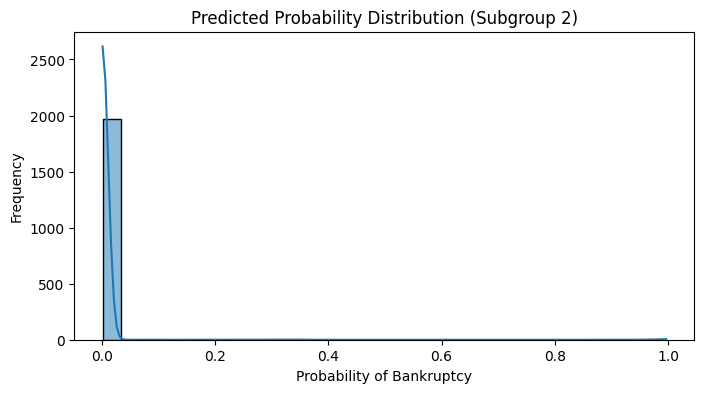

In [7]:
plt.figure(figsize=(8,4))
sns.histplot(probs_full, kde=True, bins=30)
plt.title("Predicted Probability Distribution (Subgroup 2)")
plt.xlabel("Probability of Bankruptcy")
plt.ylabel("Frequency")
plt.show()

In [8]:
pca_reducer = model.named_steps["preprocess"].transformers_[0][1]
Nfeatures = pca_reducer.named_steps["pca"].n_components_
print("Nfeatures =", Nfeatures)


Nfeatures = 40


<h3> Threshold Tuning on FULL Subgroup Data</h3>

In [9]:
def evaluate_threshold(y_true, probs, thr, max_fraction=0.20):
    y_pred = (probs >= thr).astype(int)
    n_pred = y_pred.sum()

    # enforce 20% predicted bankrupt rule
    if n_pred > max_fraction * len(y_true):
        return -1, 0, 0, n_pred

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    acc = 0 if (tp + fn == 0) else tp / (tp + fn)
    return acc, tp, fn, n_pred

# Threshold Search
best = {"thr": None, "acc": -1}

for thr in np.linspace(0.01, 0.99, 300):
    acc, TT_t, TF_t, n_pred = evaluate_threshold(y, probs_full, thr)
    if acc > best["acc"] and acc != -1:
        best.update({
            "thr": float(thr),
            "acc": float(acc),
            "TT": int(TT_t),
            "TF": int(TF_t),
            "n_pred": int(n_pred)
        })

print("\nBest threshold result:\n", best)

BEST_THRESHOLD = best["thr"]
print("\nFinal chosen threshold:", BEST_THRESHOLD)



Best threshold result:
 {'thr': 0.01, 'acc': 1.0, 'TT': 4, 'TF': 0, 'n_pred': 6}

Final chosen threshold: 0.01


<h3>Threshold vs Positive rate</h3>

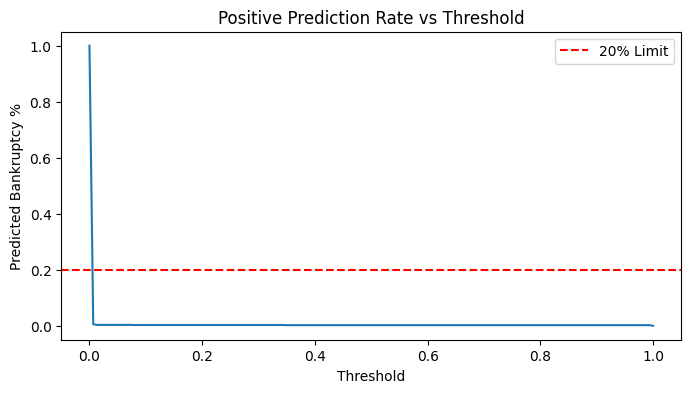

In [10]:
thresholds = np.linspace(0, 1, 150)
positive_rates = [(probs_full >= t).mean() for t in thresholds]

plt.figure(figsize=(8,4))
plt.plot(thresholds, positive_rates)
plt.axhline(0.20, color='red', linestyle='--', label='20% Limit')
plt.title("Positive Prediction Rate vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Predicted Bankruptcy %")
plt.legend()
plt.show()


<h3> Compute Final TT and TF for Table 3</h3>

In [11]:
def predict_with_threshold(model, X, threshold):
    proba = model.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

y_pred_final = predict_with_threshold(model, X, BEST_THRESHOLD)

tn, fp, fn, tp = confusion_matrix(y, y_pred_final).ravel()

TT = int(tp)
TF = int(fn)
predicted_positives = int(y_pred_final.sum())
rate = predicted_positives / len(y)

eq1 = TT / (TT + TF) if (TT + TF) > 0 else 0

print("\n FINAL SUBGROUP 2 RESULTS")
print("Threshold =", BEST_THRESHOLD)
print("TT =", TT)
print("TF =", TF)
print("FP =", fp)
print("TN =", tn)
print("Eq(1) =", eq1)
print("Predicted bankrupts:", predicted_positives, "out of", len(y), "| rate =", rate)



 FINAL SUBGROUP 2 RESULTS
Threshold = 0.01
TT = 4
TF = 0
FP = 2
TN = 1970
Eq(1) = 1.0
Predicted bankrupts: 6 out of 1976 | rate = 0.003036437246963563


<h3>Final Confusion Matrix</h3>

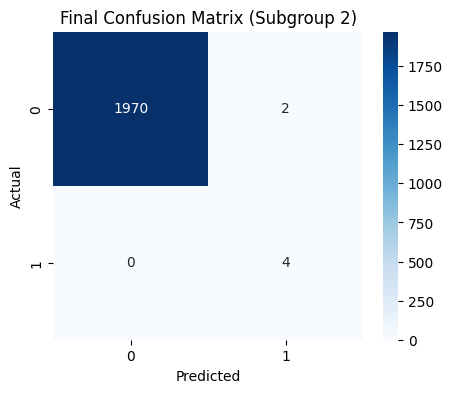

In [12]:
cm = confusion_matrix(y, y_pred_final)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Final Confusion Matrix (Subgroup 2)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3>Save Model Object</h3>

In [ ]:
model_obj = {
    "pipeline": model,
    "threshold": BEST_THRESHOLD,
    "feature_names": X.columns.tolist()
}

joblib.dump(model_obj, "models/subgroup2_cluster2_model.joblib")
print("\nModel saved as: models/subgroup2_cluster2_model.joblib")


Model saved as: models/subgroup2_cluster2_model.joblib
